# Machine Learning for Time Series Data in Python

Time series data is ubiquitous. Whether it be stock market fluctuations, sensor data recording climate change, or activity in the brain, any signal that changes over time can be described as a time series. Machine learning has emerged as a powerful method for leveraging complexity in data in order to generate predictions and insights into the problem one is trying to solve. This course is an intersection between these two worlds of machine learning and time series data, and covers feature engineering, spectograms, and other advanced techniques in order to classify heartbeat sounds and predict stock prices.

In [61]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import librosa as lr
from librosa.core import stft, amplitude_to_db
from librosa.display import specshow
from glob import glob


from sklearn.svm import LinearSVC
from sklearn.linear_model import Ridge, LinearRegression
from sklearn.model_selection import train_test_split, cross_val_score, KFold, ShuffleSplit, TimeSeriesSplit
from sklearn.metrics import r2_score
from sklearn.utils import resample

# Import partial from functools
from functools import partial

## 1. Time Series and Machine Learning Primer

This chapter is an introduction to the basics of machine learning, time series data, and the intersection between the two.

We'll explore the two datasets we'll use in this course.

The first is a collection of heartbeat sounds. Hearts normally have a predictable sound pattern as they beat, but some disorders can cause the heart to beat abnormally. This dataset contains a training set with labels for each type of heartbeat, and a testing set with no labels. We'll use the testing set to validate our models.

As we have labeled data, this dataset is ideal for classification. In fact, it was originally offered as a part of a [public Kaggle competition](https://www.kaggle.com/datasets/kinguistics/heartbeat-sounds?resource=download).

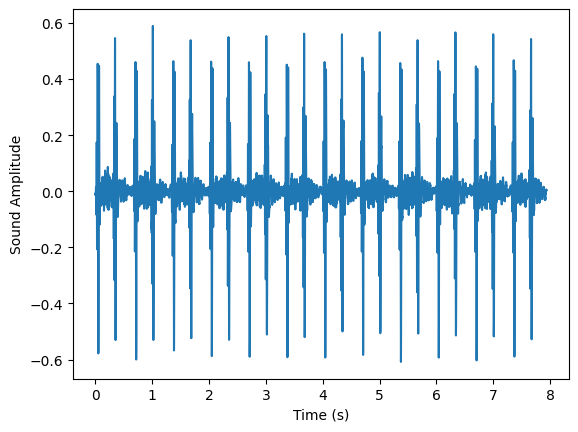

In [2]:
# List all the wav files in the folder
data_dir = 'data_4'
audio_files = glob(data_dir + '/*.wav')

# Read in the first audio file, create the time array
audio, sfreq = lr.load(audio_files[0])
time = np.arange(0, len(audio)) / sfreq

# Plot audio over time
fig, ax = plt.subplots()
ax.plot(time, audio)
ax.set(xlabel='Time (s)', ylabel='Sound Amplitude')
plt.show()

There are several seconds of heartbeat sounds in here, though note that most of this time is silence. A common procedure in machine learning is to separate the datapoints with lots of stuff happening from the ones that don't.

The next dataset contains information about company market value over several years of time. This is one of the most popular kind of time series data used for regression. If we can model the value of a company as it changes over time, we can make predictions about where that company will be in the future. This dataset was also originally provided as part of a [public Kaggle competition](https://www.kaggle.com/datasets/dgawlik/nyse).

In this exercise, you'll plot the time series for a number of companies to get an understanding of how they are (or aren't) related to one another.

In [3]:
# Read in the data
data = pd.read_csv(data_dir + '/prices.csv', index_col='date', parse_dates=True)


company_list = ['AAPL', 'FB', 'NFLX', 'V', 'XOM']

close_price_list = []

for company in company_list:
    company_price = data.loc[ data['symbol'] == company, ['close']].copy()
    company_price.rename(columns={"close": company}, inplace=True)
    close_price_list.append( company_price )

    
prices = pd.concat(close_price_list, axis=1)
prices.head()

,AAPL,FB,NFLX,V,XOM
date,,,,,
2010-01-04,214.009998,NaN,53.479999,88.139999,69.150002
2010-01-05,214.379993,NaN,51.510001,87.129997,69.419998
2010-01-06,210.969995,NaN,53.319999,85.959999,70.019997
2010-01-07,210.580000,NaN,52.400001,86.760002,69.800003
2010-01-08,211.980005,NaN,53.300002,87.000000,69.519997


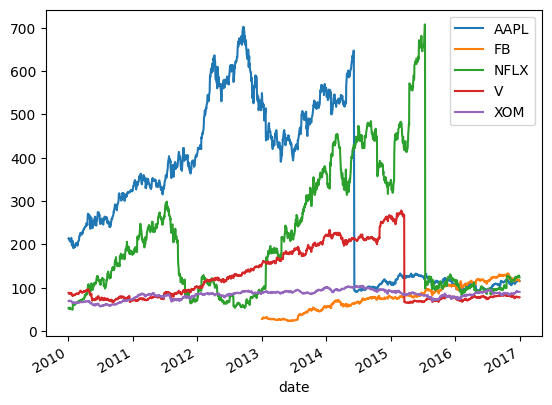

In [4]:
# Loop through each column, plot its values over time
fig, ax = plt.subplots()
for column in prices.columns:
    prices[column].plot(ax=ax, label=column)
ax.legend()
plt.show()

Note that each company's value is sometimes correlated with others, and sometimes not. Also note there are a lot of 'jumps' in there - what effect do you think these jumps would have on a predictive model?

## 2. Time Series as Inputs to a Model

The easiest way to incorporate time series into your machine learning pipeline is to use them as features in a model. This chapter covers common features that are extracted from time series in order to do machine learning.

#### Classification and feature engineering

In this exercise, we'll start with perhaps the simplest classification technique: averaging across dimensions of a dataset and visually inspecting the result.

We'll use the heartbeat data described in the last chapter. Some recordings are normal heartbeat activity, while others are abnormal activity. Let's see if we can spot the difference.

Two [DataFrames](https://github.com/goodboychan/goodboychan.github.io/blob/main/_notebooks/dataset/heart_normal.csv), `heart_normal` and `heart_abnormal`, each with the shape of `(n_times_points, n_audio_files)` containing the audio for several heartbeats are available. Also, the sampling frequency is loaded into a variable called `sfreq`. A convenience plotting function `show_plot_and_make_titles()` is also available in your workspace.

In [5]:
def show_plot_and_make_titles():
   axs[0, 0].set(title="Normal Heartbeats")
   axs[0, 1].set(title="Abnormal Heartbeats")
   plt.tight_layout()
   plt.show()

In [6]:
sfreq = 2205

heart_normal = pd.read_csv(data_dir + '/heart_normal.csv', index_col='time')
heart_abnormal = pd.read_csv(data_dir + '/heart_abnormal.csv', index_col='time')

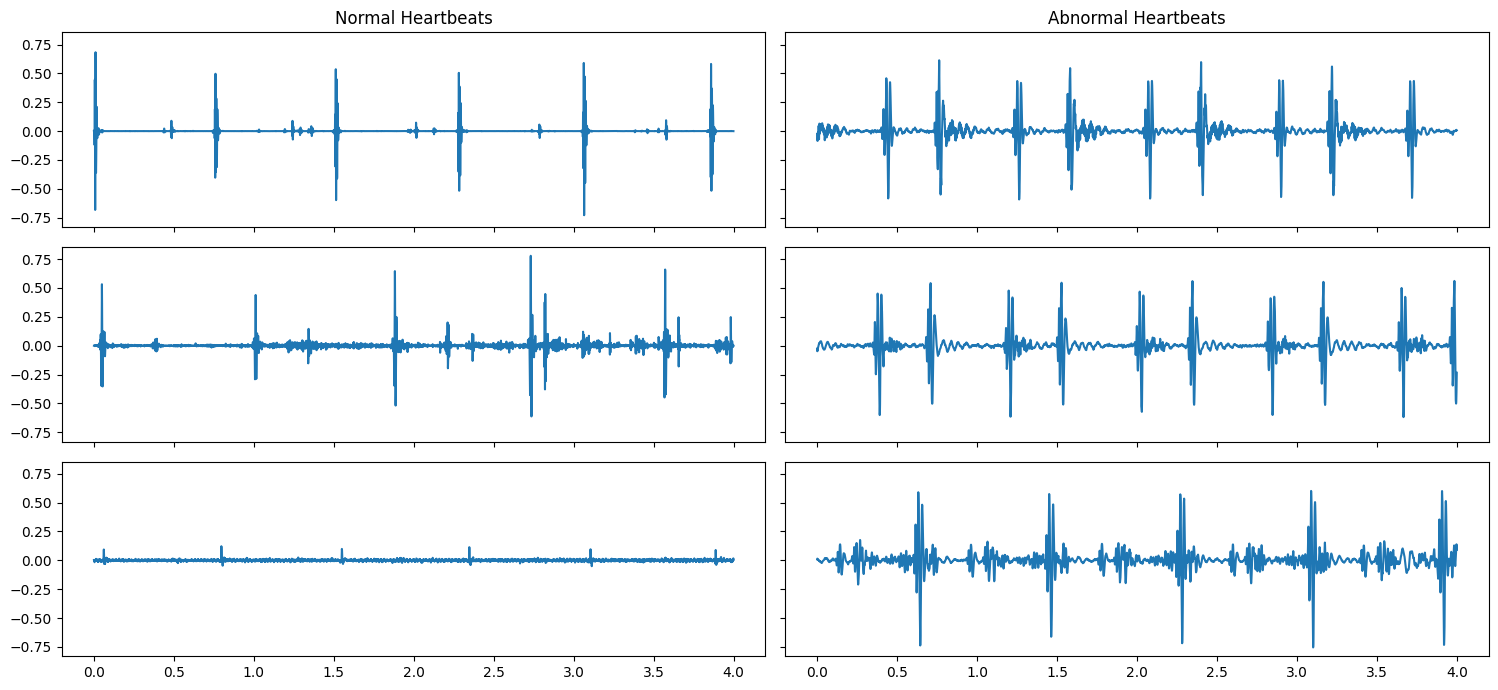

In [7]:
fig, axs = plt.subplots(3, 2, figsize=(15, 7), sharex=True, sharey=True)

# Calculate the time array
time = np.arange(0, len(heart_abnormal)) / sfreq

# Stack the normal/abnormal audio so you can loop and plot
stacked_audio = np.hstack([ heart_normal[['3', '4', '6']], heart_abnormal[['0', '1', '2']] ]).T

# Loop through each audio file / ax object and plot
# .T.ravel() transposes the array, then unravels it into a 1-D vector for looping
for iaudio, ax in zip(stacked_audio, axs.T.ravel()):
    ax.plot(time, iaudio)
show_plot_and_make_titles()

While we should always start by visualizing our raw data, this is often uninformative when it comes to discriminating between two classes of data points. Data is usually noisy or exhibits complex patterns that aren't discoverable by the naked eye.

Another common technique to find simple differences between two sets of data is to average across multiple instances of the same class. This may remove noise and reveal underlying patterns (or, it may not).

In this exercise, we'll average across many instances of each class of heartbeat sound.

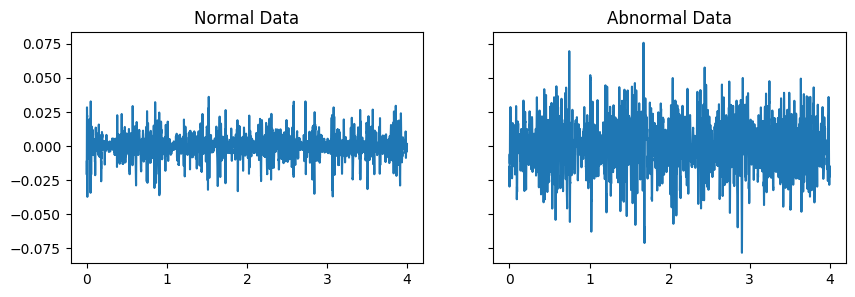

In [8]:
# Average across the audio files of each DataFrame
mean_normal = np.mean(heart_normal, axis=1)
mean_abnormal = np.mean(heart_abnormal, axis=1)

# Plot each average over time
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 3), sharey=True)
ax1.plot(time, mean_normal)
ax1.set(title="Normal Data")
ax2.plot(time, mean_abnormal)
ax2.set(title="Abnormal Data")
plt.show()

Do you see a noticeable difference between the two? Maybe, but it's quite noisy. Let's see how we can dig into the data a bit further.

While eye-balling differences is a useful way to gain an intuition for the data, let's see if we can operationalize things with a model. In this exercise, we will use each repetition as a datapoint, and each moment in time as a feature to fit a classifier that attempts to predict abnormal vs. normal heartbeats using only the raw data.

In [9]:
trans_heart_normal = heart_normal.T
trans_heart_normal['label'] = 'normal'
trans_heart_abnormal = heart_abnormal.T
trans_heart_abnormal['label'] = 'abnormal'

heart_data = pd.concat([trans_heart_normal, trans_heart_abnormal])

X_train, X_test, y_train, y_test = train_test_split(heart_data.loc[:, heart_data.columns != 'label'], 
                                                    heart_data['label'], 
                                                    test_size=0.7, 
                                                    random_state=42)

In [10]:
y_train

39      normal
6       normal
41    abnormal
22    abnormal
11    abnormal
43      normal
44    abnormal
20      normal
40      normal
33      normal
59    abnormal
38      normal
16      normal
29    abnormal
26      normal
55      normal
46    abnormal
19    abnormal
Name: label, dtype: object

In [11]:
# Initialize and fit the model
model = LinearSVC()
model.fit(X_train, y_train)

# Generate predictions and score them manually
predictions = model.predict(X_test)
print(sum(predictions == y_test.squeeze()) / len(y_test))

0.5


Note that our predictions didn't do so well. That's because the features we're using as inputs to the model (raw data) aren't very good at differentiating classes. Next, we'll explore how to calculate some more complex features that may improve the results.

#### Improving the features we use for classification

One of the ways we can improve the features available to our model is to remove some of the noise present in the data. In audio data, a common way to do this is to smooth the data and then rectify it so that the total amount of sound energy over time is more distinguishable. We'll do this in the current exercise.

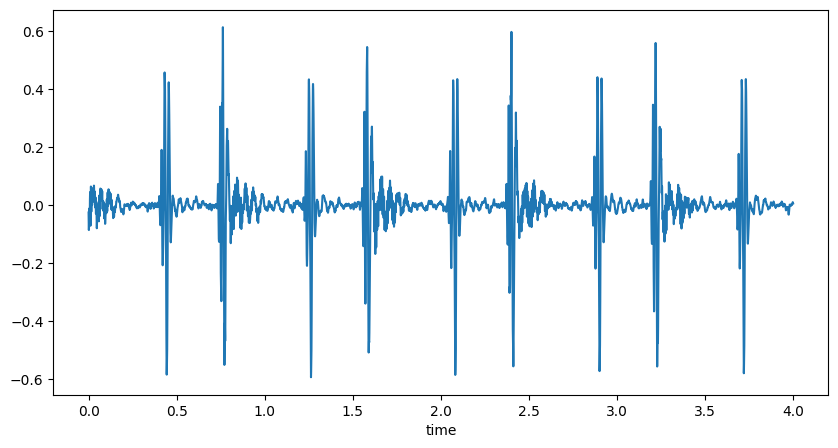

In [12]:
audio = heart_abnormal['0']
# Plot the raw data first
audio.plot(figsize=(10, 5))
plt.show()

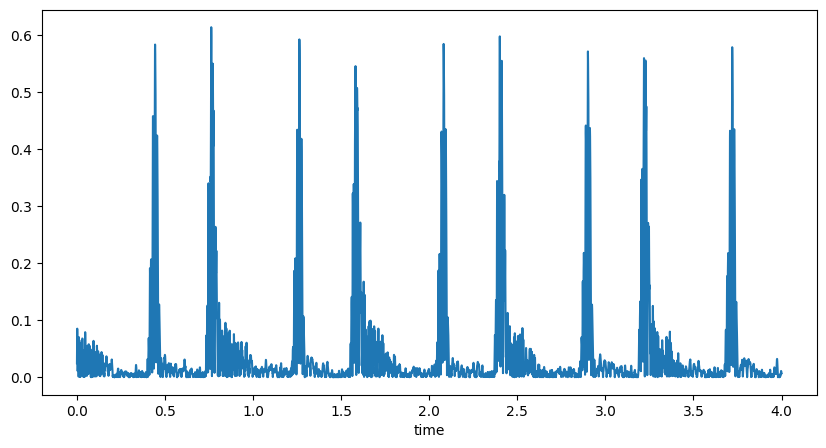

In [13]:
# Rectify the audio signal
audio_rectified = audio.apply(np.abs)

# Plot the result
audio_rectified.plot(figsize=(10, 5))
plt.show()

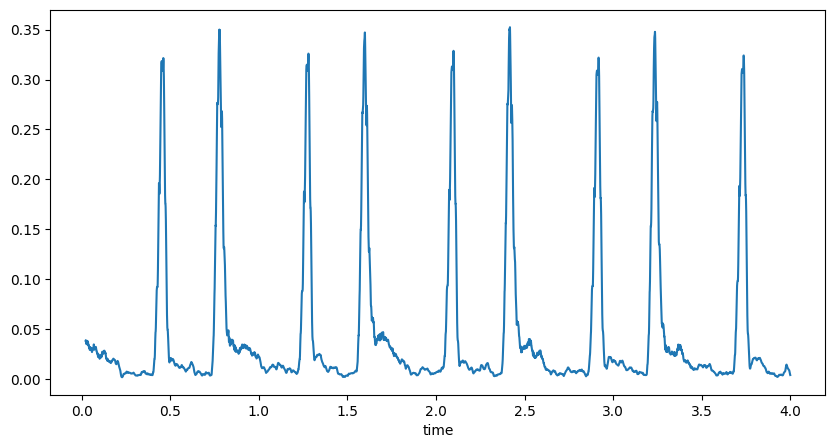

In [14]:
# Smooth by applying a rolling mean
audio_rectified_smooth = audio_rectified.rolling(50).mean()

# Plot the result
audio_rectified_smooth.plot(figsize=(10, 5))
plt.show()

By calculating the envelope of each sound and smoothing it, we've eliminated much of the noise and have a cleaner signal to tell us when a heartbeat is happening.

Now that we've removed some of the noisier fluctuations in the audio, let's see if this improves our ability to classify. 

In [15]:
audio = pd.concat([heart_normal, heart_abnormal], axis=1)
y = list(trans_heart_normal['label']) + list(trans_heart_abnormal['label'])
# Rectify the audio signal
audio_rectified = audio.apply(np.abs)
# Smooth by applying a rolling mean
audio_rectified_smooth = audio_rectified.rolling(50).mean()
audio_rectified_smooth

,3,4,6,7,10,12,15,16,17,18,...,45,46,47,50,53,54,56,57,58,59
time,,,,,,,,,,,,,,,,,,,,,
0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0.000454,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0.000907,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0.001361,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0.001814,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3.997732,0.000319,0.052274,0.004678,0.009189,0.000768,0.025388,0.012852,0.004383,0.000498,0.006112,...,0.038151,0.103593,0.020681,0.038664,0.016904,0.022293,0.013043,0.001105,0.017127,0.016632
3.998186,0.000316,0.052350,0.004708,0.009258,0.000728,0.025417,0.012819,0.004387,0.000492,0.006170,...,0.037824,0.105708,0.020671,0.037305,0.017210,0.021217,0.012920,0.001104,0.017448,0.016551
3.998639,0.000319,0.052310,0.005010,0.009341,0.000676,0.025516,0.012858,0.004384,0.000495,0.006085,...,0.037302,0.108514,0.020536,0.035876,0.017372,0.020081,0.012806,0.001108,0.017796,0.016419


In [16]:
# Calculate stats
means = np.mean(audio_rectified_smooth, axis=0)
stds = np.std(audio_rectified_smooth, axis=0)
maxs = np.max(audio_rectified_smooth, axis=0)

# Create the X and y arrays
X = np.column_stack([means, stds, maxs])

# Fit the model and score on testing data

percent_score = cross_val_score(model, X, y, cv=5)
print(np.mean(percent_score))

0.7


This model is both simpler (only 3 features) and more understandable (features are simple summary statistics of the data).

One benefit of cleaning up our data is that it lets us compute more sophisticated features. For example, the envelope calculation we performed is a common technique in computing tempo and rhythm features. In this exercise, we'll use `librosa` to compute some tempo and rhythm features for heartbeat data, and fit a model once more.

Note that `librosa` functions tend to only operate on numpy arrays instead of DataFrames, so we'll access our Pandas data as a __Numpy array__ with the `.values` attribute.

In [17]:
# Calculate the tempo of the sounds
tempos = []
for col, i_audio in audio.items():
    tempos.append(lr.feature.tempo(y = i_audio.values, sr=sfreq, hop_length=2**6, aggregate=None))

# Convert the list to an array so you can manipulate it more easily
tempos = np.array(tempos)

# Calculate statistics of each tempo
tempos_mean = tempos.mean(axis=-1)
tempos_std = tempos.std(axis=-1)
tempos_max = tempos.max(axis=-1)

In [18]:
# Create the X and y arrays
X = np.column_stack([means, stds, maxs, tempos_mean, tempos_std, tempos_max])

# Fit the model and score on testing data
percent_score = cross_val_score(model, X, y, cv=5)
print(np.mean(percent_score))

0.4833333333333333


C:\Users\DmitriGazizulin\AppData\Roaming\Python\Python310\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\DmitriGazizulin\AppData\Roaming\Python\Python310\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\DmitriGazizulin\AppData\Roaming\Python\Python310\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\DmitriGazizulin\AppData\Roaming\Python\Python310\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\DmitriGazizulin\AppData\Roaming\Python\Python310\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.w

Note that our predictive power may not have gone up (because this dataset is quite small), but we now have a more rich feature representation of audio that your model can use!

#### The spectrogram - spectral changes to sound over time

Spectral engineering is one of the most common techniques in machine learning for time series data. The first step in this process is to calculate a spectrogram of sound. This describes what spectral content (e.g., low and high pitches) are present in the sound over time. In this exercise, we'll calculate a spectrogram of a heartbeat audio file.

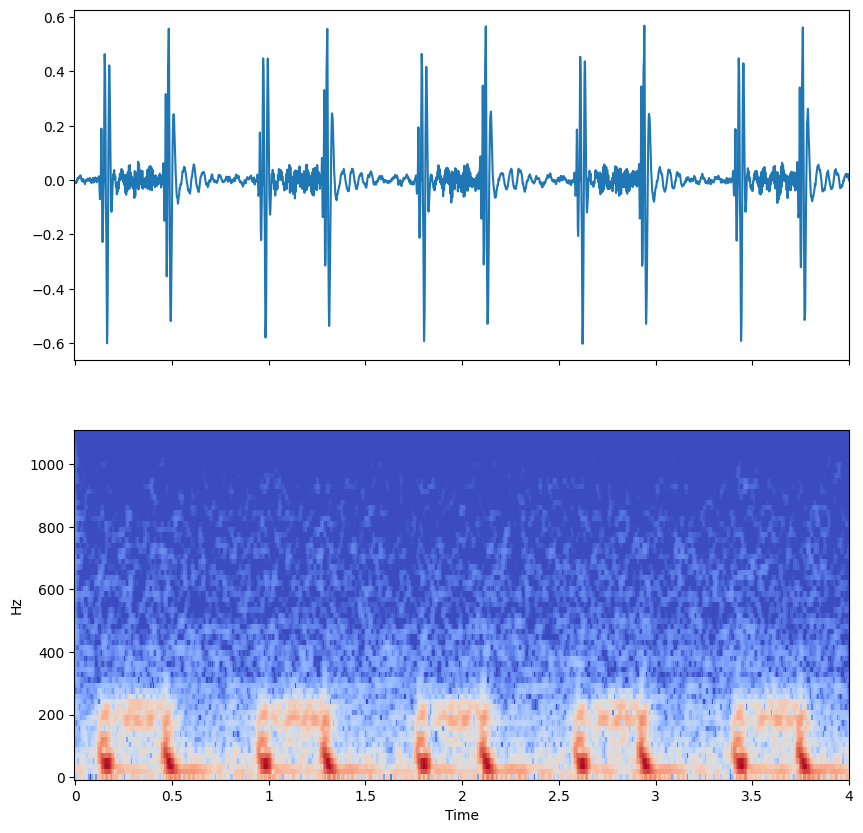

In [19]:
single_audio = audio['59']

# Prepare the STFT
HOP_LENGTH = 2**4
SIZE_WINDOW = 2**7
spec = stft(single_audio.values, hop_length=HOP_LENGTH, n_fft=SIZE_WINDOW)

# Convert into decibels
spec_db = amplitude_to_db(np.abs(spec))

# Compare the raw audio to the spectrogram of the audio
fig, axs = plt.subplots(2, 1, figsize=(10, 10), sharex=True)
axs[0].plot(time, single_audio)
specshow(spec_db, sr=sfreq, x_axis='time', y_axis='hz', hop_length=HOP_LENGTH, ax=axs[1])
plt.show()

As we can probably tell, there is a lot more information in a spectrogram compared to a raw audio file. By computing the spectral features, we have a much better idea of what's going on. As such, there are all kinds of spectral features that we can compute using the spectrogram as a base. In this exercise, we'll look at a few of these features.

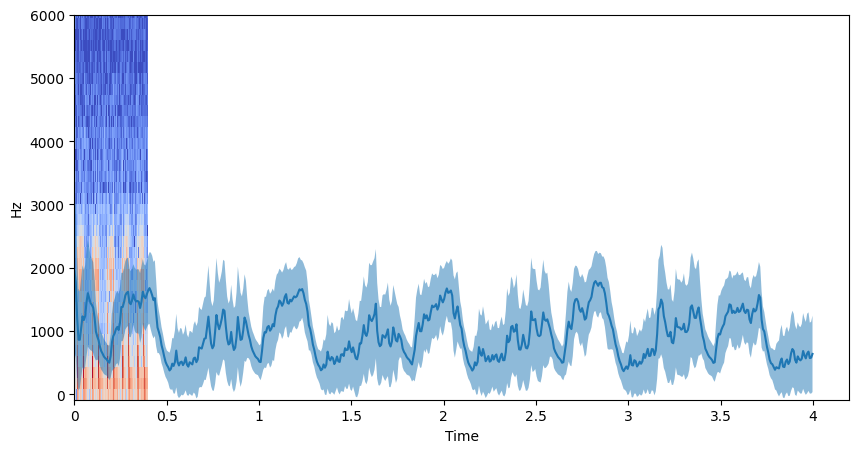

In [20]:
# Calculate the spectral centroid and bandwidth for the spectrogram
bandwidths = lr.feature.spectral_bandwidth(S=np.abs(spec))[0]
centroids = lr.feature.spectral_centroid(S=np.abs(spec))[0]

# Convert spectrogram to decibels for visualization
spec_db = amplitude_to_db(np.abs(spec))

# Display these features on top of the spectrogram
fig, ax = plt.subplots(figsize=(10, 5))
specshow(spec_db, x_axis='time', y_axis='hz', hop_length=HOP_LENGTH, n_fft=SIZE_WINDOW, ax=ax)

dt = 2 * SIZE_WINDOW / HOP_LENGTH / sfreq
times_spec = np.arange(0, len(bandwidths)) * dt
ax.plot(times_spec, centroids)
ax.fill_between(times_spec, centroids - bandwidths / 2, centroids + bandwidths / 2, alpha=.5)
ax.set(ylim=[None, 6000])
plt.show()

As we can see, the spectral centroid and bandwidth characterize the spectral content in each sound over time. They give us a summary of the spectral content that we can use in a classifier.

We've spent this lesson engineering many features from the audio data - some contain information about how the audio changes in time, others contain information about the spectral content that is present.

The beauty of machine learning is that it can handle all of these features at the same time. If there is different information present in each feature, it should improve the classifier's ability to distinguish the types of audio. Note that this often requires more advanced techniques such as regularization, which we'll cover in the next chapter.

In [21]:
# Loop through each spectrogram
bandwidths = []
centroids = []

for _,single_audio in audio.iteritems():
    spec = stft(single_audio.values, hop_length=HOP_LENGTH, n_fft=SIZE_WINDOW)
    spec = np.abs(spec)
    # Convert into decibels
    spec_db = amplitude_to_db(spec)
    # Calculate the mean spectral bandwidth
    this_mean_bandwidth = np.mean(lr.feature.spectral_bandwidth(S=spec))
    # Calculate the mean spectral centroid
    this_mean_centroid = np.mean(lr.feature.spectral_centroid(S=spec))
    # Collect the values
    bandwidths.append(this_mean_bandwidth)  
    centroids.append(this_mean_centroid)


# Create X and y arrays
X = np.column_stack([bandwidths, centroids])

# Fit the model and score on testing data
percent_score = cross_val_score(model, X, y, cv=5)
print(np.mean(percent_score))

0.5166666666666667


C:\Users\DmitriGazizulin\AppData\Local\Temp\ipykernel_43536\3754188250.py:5: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for _,single_audio in audio.iteritems():
C:\Users\DmitriGazizulin\AppData\Roaming\Python\Python310\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\DmitriGazizulin\AppData\Roaming\Python\Python310\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\DmitriGazizulin\AppData\Roaming\Python\Python310\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\DmitriGazizulin\AppData\Roaming\Python\Python310\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of itera

We calculated many different features of the audio, and combined each of them under the assumption that they provide independent information that can be used in classification. We may have noticed that the accuracy of our models varied a lot when using different set of features. This chapter was focused on creating new "features" from raw data and not obtaining the best accuracy. To improve the accuracy, we want to find the right features that provide relevant information and also build models on much larger data.

## 3. Predicting Time Series Data

If you want to predict patterns from data over time, there are special considerations to take in how you choose and construct your model. This chapter covers how to gain insights into the data before fitting your model, as well as best-practices in using predictive modeling for time series data.

#### Predicting data over time

We'll deal with stock market prices that fluctuate over time. In this exercise we've got historical prices from two tech companies (Ebay and Yahoo) in the DataFrame `prices`. We'll visualize the raw data for the two companies, then generate a scatter plot showing how the values for each company compare with one another. Finally, we'll add in a "time" dimension to our scatter plot so we can see how this relationship changes over time.

In [22]:
# Read in the data
prices_raw = pd.read_csv(data_dir + '/prices.csv', index_col='date', parse_dates=True)


company_list = ['EBAY', 'YHOO']

close_price_list = []

for company in company_list:
    company_price = prices_raw.loc[ prices_raw['symbol'] == company, ['close']].copy()
    company_price.rename(columns={"close": company}, inplace=True)
    close_price_list.append( company_price )

    
prices = pd.concat(close_price_list, axis=1)
prices.head()

,EBAY,YHOO
date,,
2010-01-04,23.900000,17.100000
2010-01-05,23.650000,17.230000
2010-01-06,23.500000,17.170000
2010-01-07,23.229998,16.700001
2010-01-08,23.509999,16.700001


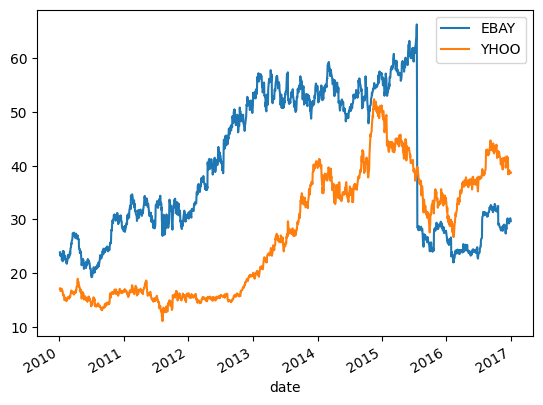

In [23]:
# Plot the raw values over time
prices.plot()
plt.show()

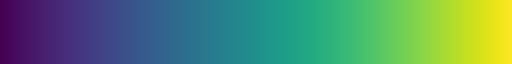

In [24]:
plt.cm.viridis

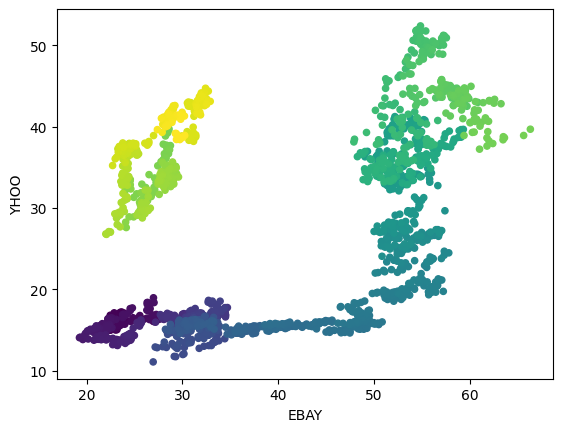

In [25]:
# Scatterplot with color relating to time
prices.plot.scatter('EBAY', 'YHOO', c = prices.index, colorbar=False)
plt.show()

As we can see, these two time series seem somewhat related to each other, though its a complex relationship that changes over time.

Now we'll look at a larger number of companies. Recall that we have historical price values for many companies. Let's use data from several companies to predict the value of a test company. We'll attempt to predict the value of the Apple stock price using the values of NVidia, Ebay, and Yahoo. Each of these is stored as a column in the `all_prices` DataFrame.

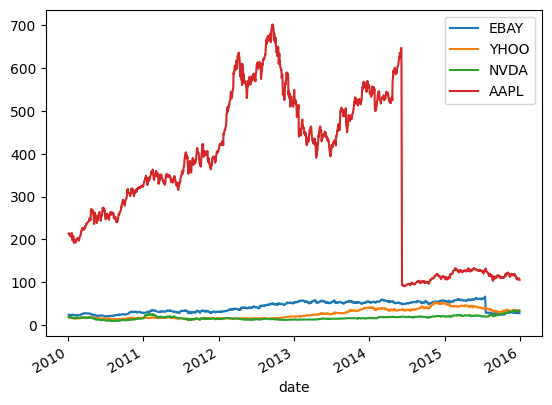

In [26]:
company_list = ['EBAY', 'YHOO', 'NVDA', 'AAPL']

close_price_list = []

for company in company_list:
    company_price = prices_raw.loc[ prices_raw['symbol'] == company, ['close']].copy()
    company_price.rename(columns={"close": company}, inplace=True)
    close_price_list.append( company_price )

    
all_prices = pd.concat(close_price_list, axis=1)
all_prices = all_prices.loc[:'2015']
all_prices.plot()
plt.show()

In [27]:
# Use stock symbols to extract training data
X = all_prices[['EBAY','NVDA', 'YHOO']].values
y = all_prices['AAPL'].values

# Fit and score the model with cross-validation
scores = cross_val_score(Ridge(), X, y, cv=3)
print(scores)

[-11.01746247  -2.47902428  -0.54128128]


As we can see, fitting a model with raw data doesn't give great results.

When dealing with time series data, it's useful to visualize model predictions on top of the "actual" values that are used to test the model.

In this exercise, after splitting the data (stored in the variables `X` and `y`) into training and test sets, we'll build a model and then visualize the model's predictions on top of the testing data in order to estimate the model's performance.

-390.10770147467304


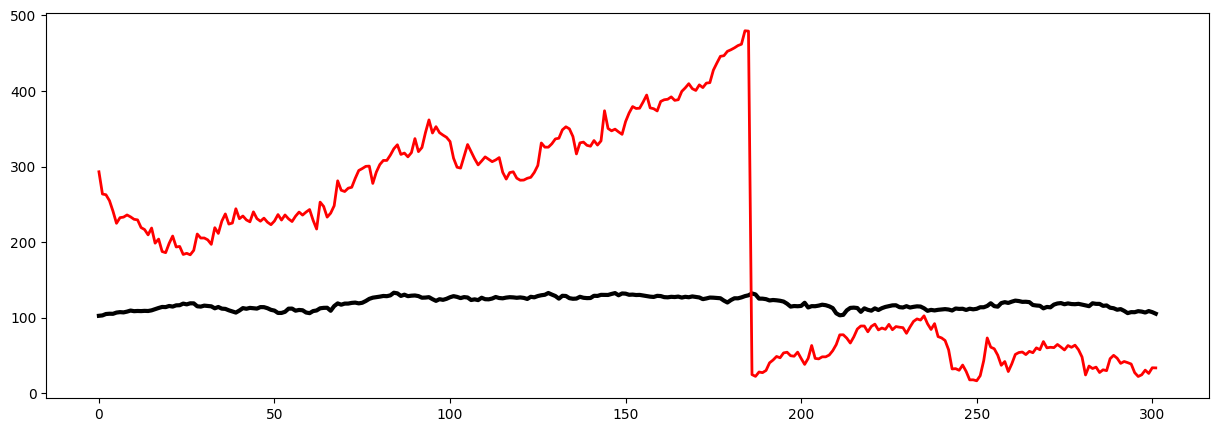

In [28]:
# Split our data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=.8, shuffle=False)

# Fit our model and generate predictions
model = Ridge()
model.fit(X_train, y_train)
predictions = model.predict(X_test)
score = r2_score(y_test, predictions)
print(score)

# Visualize our predictions along with the "true" values, and print the score
fig, ax = plt.subplots(figsize=(15, 5))
ax.plot(y_test, color='k', lw=3)
ax.plot(predictions, color='r', lw=2)
plt.show()

Now you have an explanation for your poor score. The predictions clearly deviate from the true time series values.

#### Advanced time series prediction

Let's take a look at a new dataset - this one is a bit less-clean than what we've seen before.

As always, we'll first start by visualizing the raw data. Let's take a close look and try to find datapoints that could be problematic for fitting models.

In [29]:
# Read in the data
prices_null = pd.read_csv(data_dir + '/prices_null.csv', index_col='date', parse_dates=True)

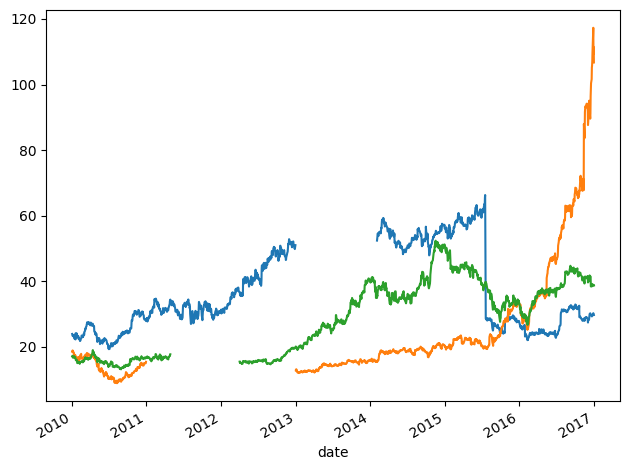

EBAY    273
NVDA    502
YHOO    232
dtype: int64


In [30]:
# Visualize the dataset
prices_null.plot(legend=False)
plt.tight_layout()
plt.show()

# Count the missing values of each time series
missing_values = prices_null.isna().sum()
print(missing_values)

In the plot, we can see there are clearly missing chunks of time in our data. There also seem to be a few 'jumps' in the data. How can you deal with this?

When we have missing data points, how can we fill them in?

In this exercise, we'll practice using different interpolation methods to fill in some missing values, visualizing the result each time. But first, we will create the function (`interpolate_and_plot()`) we'll use to interpolate missing data points and plot them.

In [31]:
# Create a function we'll use to interpolate and plot
def interpolate_and_plot(prices, interpolation):

    # Create a boolean mask for missing values
    missing_values = prices.isna()

    # Interpolate the missing values
    prices_interp = prices.interpolate(interpolation)

    # Plot the results, highlighting the interpolated values in black
    fig, ax = plt.subplots(figsize=(10, 5))
    prices_interp.plot(color='k', alpha=.6, ax=ax, legend=False)
    
    # Now plot the interpolated values on top in red
    prices_interp[missing_values].plot(ax=ax, color='r', lw=3, legend=False)
    plt.show()

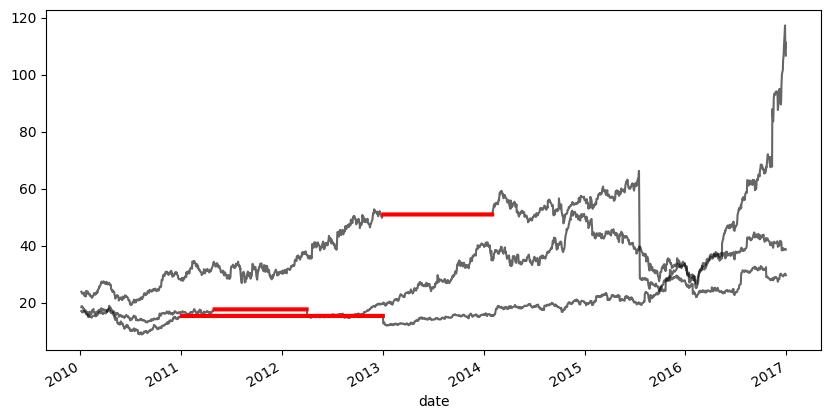

In [32]:
# Interpolate using the latest non-missing value
interpolation_type = 'zero'
interpolate_and_plot(prices_null, interpolation_type)

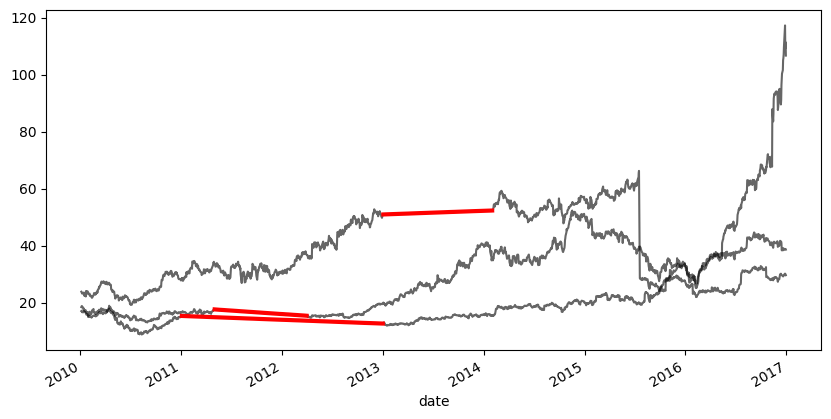

In [33]:
# Interpolate linearly
interpolation_type = 'linear'
interpolate_and_plot(prices_null, interpolation_type)

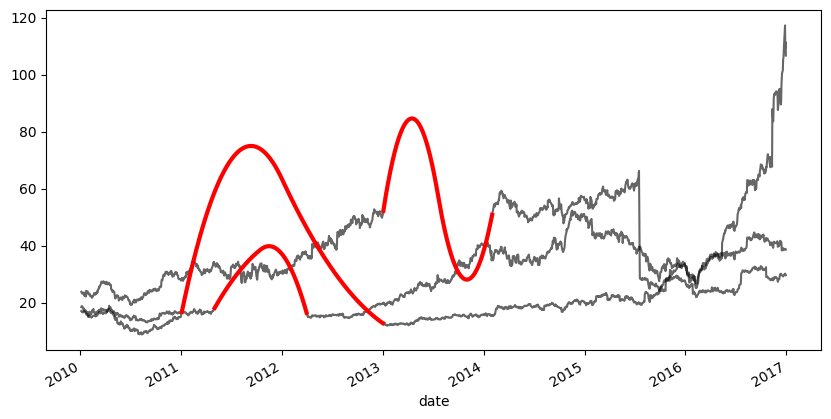

In [34]:
# Interpolate with a quadratic function
interpolation_type = 'quadratic'
interpolate_and_plot(prices_null, interpolation_type)

When we interpolate, the pre-existing data is used to infer the values of missing data. As we can see, the method we use for this has a big effect on the outcome.

In the last chapter, we calculated the rolling mean. In this exercise, we will define a function that calculates the percent change of the latest data point from the mean of a window of previous data points. This function will help us calculate the percent change over a rolling window.

This is a more stable kind of time series that is often useful in machine learning.

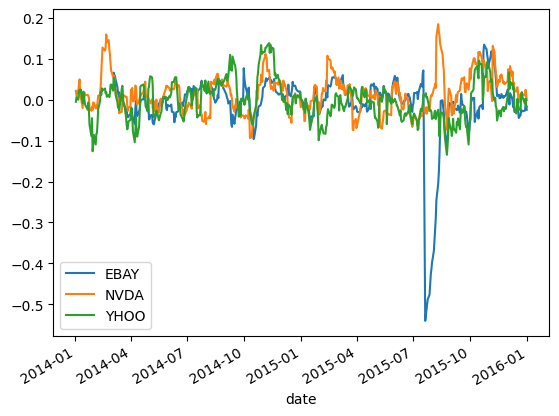

In [35]:
# Your custom function
def percent_change(series):
    # Collect all *but* the last value of this window, then the final value
    previous_values = series[:-1]
    last_value = series[-1]

    # Calculate the % difference between the last value and the mean of earlier values
    percent_change = (last_value - np.mean(previous_values)) / np.mean(previous_values)
    return percent_change

# Apply your custom function and plot
prices_perc = prices_null.rolling(20).aggregate(percent_change)
prices_perc.loc["2014":"2015"].plot()
plt.show()

We've converted the data so it's easier to compare one time point to another. This is a cleaner representation of the data.

In this exercise, we'll handle outliers - data points that are so different from the rest of our data, that we treat them differently from other "normal-looking" data points. We'll use the output from the previous exercise (percent change over time) to detect the outliers. First we will write a function that replaces outlier data points with the median value from the entire time series.

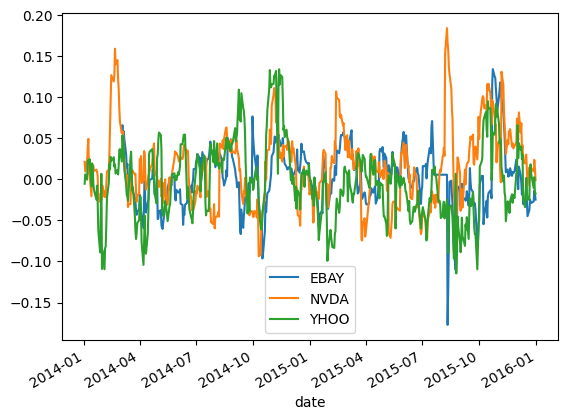

In [36]:
def replace_outliers(series):
    # Calculate the absolute difference of each timepoint from the series mean
    absolute_differences_from_mean = np.abs(series - np.mean(series))
    
    # Calculate a mask for the differences that are > 3 standard deviations from zero
    this_mask = absolute_differences_from_mean > (np.std(series) * 3)
    
    # Replace these values with the median accross the data
    series[this_mask] = np.nanmedian(series)
    return series

# Apply your preprocessing function to the timeseries and plot the results
prices_perc = prices_perc.apply(replace_outliers)
prices_perc.loc["2014":"2015"].plot()
plt.show()

Since we've converted the data to % change over time, it was easier to spot and correct the outliers.

#### Creating features over time

Now that we've practiced some simple feature engineering, let's move on to something more complex. We'll calculate a collection of features for our time series data and visualize what they look like over time. This process resembles how many other time series models operate.

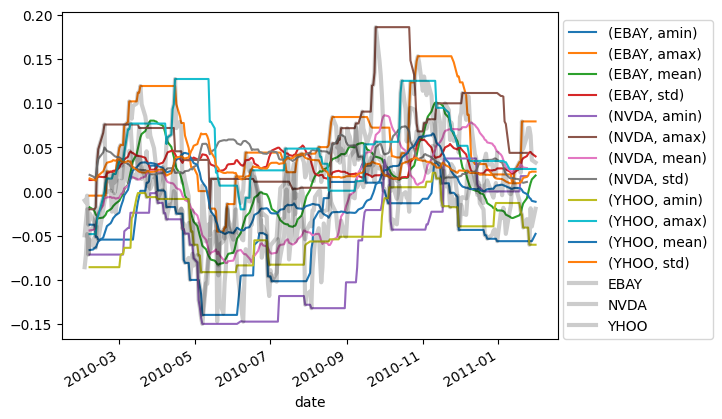

In [37]:
# Define a rolling window with Pandas, excluding the right-most datapoint of the window
prices_perc_rolling = prices_perc.rolling(20, min_periods=5, closed='right')

# Define the features you'll calculate for each window
features_to_calculate = [np.min, np.max, np.mean, np.std]

# Calculate these features for your rolling window object
features = prices_perc_rolling.aggregate(features_to_calculate)

# Plot the results
ax = features.loc[:"2011-01"].plot()
prices_perc.loc[:"2011-01"].plot(ax=ax, color='k', alpha=.2, lw=3)
ax.legend(loc=(1.01, 0))
plt.show()

In this exercise, we'll practice how to pre-choose arguments of a function so that we can pre-configure how it runs. We'll use this to calculate several percentiles of our data using the same `percentile()` function in `numpy`.

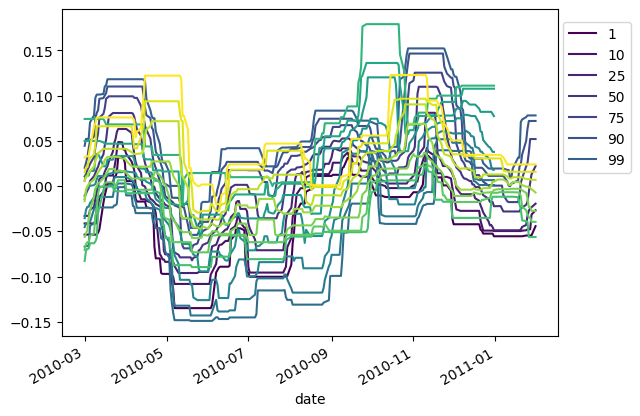

In [38]:
percentiles = [1, 10, 25, 50, 75, 90, 99]

# Use a list comprehension to create a partial function for each quantile
percentile_functions = [partial(np.percentile, q=percentile) for percentile in percentiles]

# Calculate each of these quantiles on the data using a rolling window
prices_perc_rolling = prices_perc.rolling(20, min_periods=5, closed='right')
features_percentiles = prices_perc_rolling.aggregate(percentile_functions)

# Plot a subset of the result
ax = features_percentiles.loc[:"2011-01"].plot(cmap=plt.cm.viridis)
ax.legend(percentiles, loc=(1.01, .5))
plt.show()

It's easy to think of timestamps as pure numbers, but don't forget they generally correspond to things that happen in the real world. That means there's often extra information encoded in the data such as "is it a weekday?" or "is it a holiday?". This information is often useful in predicting timeseries data.

In this exercise, we'll extract these date/time based features.

In [39]:
# Extract date features from the data, add them as columns
prices_perc['day_of_week'] = prices_perc.index.weekday
prices_perc['week_of_year'] = prices_perc.index.isocalendar().week
prices_perc['month_of_year'] = prices_perc.index.month

# Print prices_perc
display(prices_perc)

,EBAY,NVDA,YHOO,day_of_week,week_of_year,month_of_year
date,,,,,,
2010-01-04,NaN,NaN,NaN,0,1,1
2010-01-05,NaN,NaN,NaN,1,1,1
2010-01-06,NaN,NaN,NaN,2,1,1
2010-01-07,NaN,NaN,NaN,3,1,1
2010-01-08,NaN,NaN,NaN,4,1,1
...,...,...,...,...,...,...
2016-12-23,0.024842,0.147720,-0.038006,4,51,12
2016-12-27,0.038030,0.014446,-0.027985,1,52,12
2016-12-28,0.026925,0.117737,-0.029311,2,52,12


This concludes the third chapter. In the next chapter, we will learn advanced techniques to validate and inspect our time series models.

## 4. Validating and Inspecting Time Series Models

Once we've got a model for predicting time series data, we need to decide if it's a good or a bad model. This chapter coves the basics of generating predictions with models in order to validate them against "test" data.

#### Time-delayed features and autoregressive models

In machine learning for time series, it's common to use information about previous time points to predict a subsequent time point.

In this exercise, we'll "shift" our raw data and visualize the results. We'll use the percent change time series that we calculated in the previous chapter, this time with a very short window. A short window is important because, in a real-world scenario, we want to predict the day-to-day fluctuations of a time series, not its change over a longer window of time.

In [40]:
# Read in the data
prices_raw = pd.read_csv(data_dir + '/prices.csv', index_col='date', parse_dates=True)


company_list = ['AAPL']

close_price_list = []

for company in company_list:
    company_price = prices_raw.loc[ prices_raw['symbol'] == company, ['close']].copy()
    company_price.rename(columns={"close": company}, inplace=True)
    close_price_list.append( company_price )

    
prices = pd.concat(close_price_list, axis=1)
prices = prices['AAPL']
prices.head()

date
2010-01-04    214.009998
2010-01-05    214.379993
2010-01-06    210.969995
2010-01-07    210.580000
2010-01-08    211.980005
Name: AAPL, dtype: float64

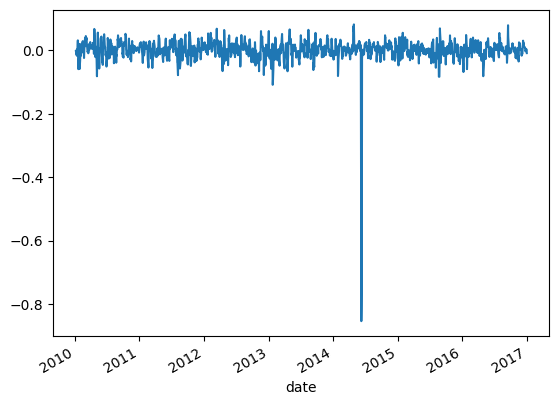

In [41]:
# Apply your custom function and plot
prices_perc = prices.rolling(5).aggregate(percent_change)
prices_perc.plot()
plt.show()

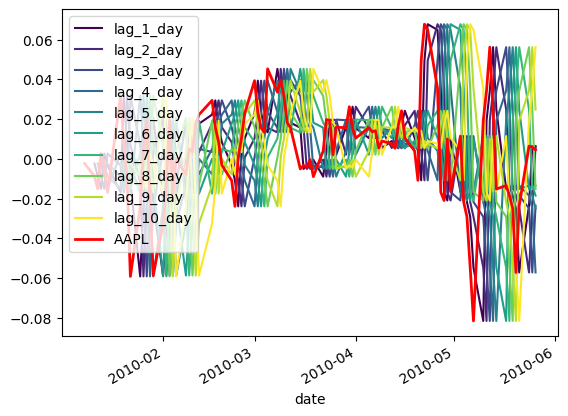

In [42]:
# These are the "time lags"
shifts = np.arange(1, 11).astype(int)

# Use a dictionary comprehension to create name: value pairs, one pair per shift
shifted_data = {"lag_{}_day".format(day_shift): prices_perc.shift(day_shift) for day_shift in shifts}

# Convert into a DataFrame for subsequent use
prices_perc_shifted = pd.DataFrame(shifted_data)

# Plot the first 100 samples of each
ax = prices_perc_shifted.iloc[:100].plot(cmap=plt.cm.viridis)
prices_perc.iloc[:100].plot(color='r', lw=2)
ax.legend(loc='best')
plt.show()

Now that we've created time-shifted versions of a single time series, we can fit an auto-regressive model. This is a regression model where the input features are time-shifted versions of the output time series data. We are using previous values of a timeseries to predict current values of the same timeseries (thus, it is auto-regressive).

By investigating the coefficients of this model, we can explore any repetitive patterns that exist in a timeseries, and get an idea for how far in the past a data point is predictive of the future.

In [43]:
# Replace missing values with the median for each column
X = prices_perc_shifted.fillna(np.nanmedian(prices_perc_shifted))
y = prices_perc.fillna(np.nanmedian(prices_perc))

# Fit the model
model = Ridge()
model.fit(X, y)

Ridge()

We've filled in the missing values with the median so that it behaves well with scikit-learn. Now let's take a look at what your model found. 

Now that we've fit the model, let's visualize its coefficients. This is an important part of machine learning because it gives you an idea for how the different features of a model affect the outcome.

In this exercise, we will create a function that, given a set of coefficients and feature names, visualizes the coefficient values.

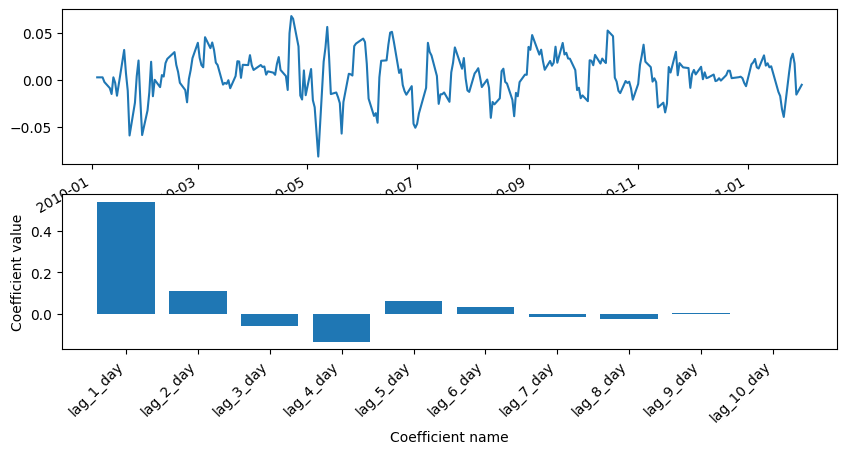

In [44]:
def visualize_coefficients(coefs, names, ax):
    # Make a bar plot for the coefficients, including their names on the x-axis
    ax.bar(names, coefs)
    ax.set(xlabel='Coefficient name', ylabel='Coefficient value')
    
    # Set formatting so it looks nice
    plt.setp(ax.get_xticklabels(), rotation=45, horizontalalignment='right')
    return ax

# Visualize the output data up to "2011-01"
fig, axs = plt.subplots(2, 1, figsize=(10, 5))
y.loc[:'2011-01'].plot(ax=axs[0])

# Run the function to visualize model's coefficients
visualize_coefficients(model.coef_, prices_perc_shifted.columns, ax=axs[1])
plt.show()

When you use time-lagged features on the raw data, you see that the highest coefficient by far is the first one. This means that the N-1th time point is useful in predicting the Nth timepoint, but no other points are useful.

Now, let's re-run the same procedure using a smoother signal. We'll use the same percent change algorithm as before, but this time use a much larger window (40 instead of 5). As the window grows, the difference between neighboring timepoints gets smaller, resulting in a smoother signal. What do you think this will do to the auto-regressive model?

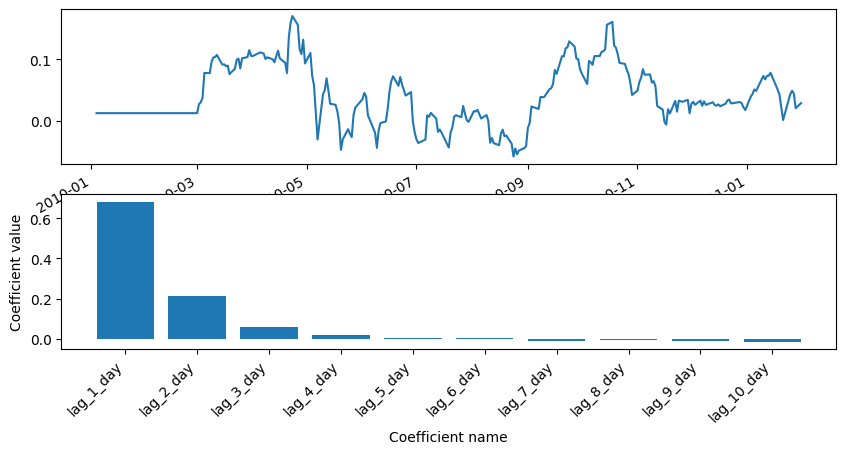

In [45]:
# Apply your custom function and plot
prices_perc = prices.rolling(40).aggregate(percent_change)

# These are the "time lags"
shifts = np.arange(1, 11).astype(int)

# Use a dictionary comprehension to create name: value pairs, one pair per shift
shifted_data = {"lag_{}_day".format(day_shift): prices_perc.shift(day_shift) for day_shift in shifts}

# Convert into a DataFrame for subsequent use
prices_perc_shifted = pd.DataFrame(shifted_data)

# Replace missing values with the median for each column
X = prices_perc_shifted.fillna(np.nanmedian(prices_perc_shifted))
y = prices_perc.fillna(np.nanmedian(prices_perc))

# Fit the model
model = Ridge()
model.fit(X, y)

# Visualize the output data up to "2011-01"
fig, axs = plt.subplots(2, 1, figsize=(10, 5))
y.loc[:'2011-01'].plot(ax=axs[0])

# Run the function to visualize model's coefficients
visualize_coefficients(model.coef_, prices_perc_shifted.columns, ax=axs[1])
plt.show()

As you can see here, by transforming our data with a larger window, we've also changed the relationship between each timepoint and the ones that come just before it. This model's coefficients gradually go down to zero, which means that the signal itself is smoother over time. Be careful when you see something like this, as it means our data is not i.i.d.

#### Cross-validating timeseries data

The cross-validation is the process of splitting our data into training and test sets multiple times. Each time we do this, we choose a different training and test set. In this exercise, we'll perform a traditional `ShuffleSplit` cross-validation on the company value data from earlier. Later we'll cover what changes need to be made for time series data. The data we'll use is the same historical price data for several large companies.

In [51]:
def visualize_predictions(results):
    fig, axs = plt.subplots(2, 1, figsize=(10, 10), sharex=True)
    
    # Loop through our model results to visualize them
    for ii, (prediction, score, indices) in enumerate(results):
        # Plot the predictions of the model in the order they were generated
        offset = len(prediction) * ii
        axs[0].scatter(np.arange(len(prediction)) + offset, prediction, label='Iteration {}'.format(ii))
        
        # Plot the predictions of the model according to how time was ordered
        axs[1].scatter(indices, prediction)
    axs[0].legend(loc="best")
    axs[0].set(xlabel="Test prediction number", title="Predictions ordered by test prediction number")
    axs[1].set(xlabel="Time", title="Predictions ordered by time")
    plt.show()

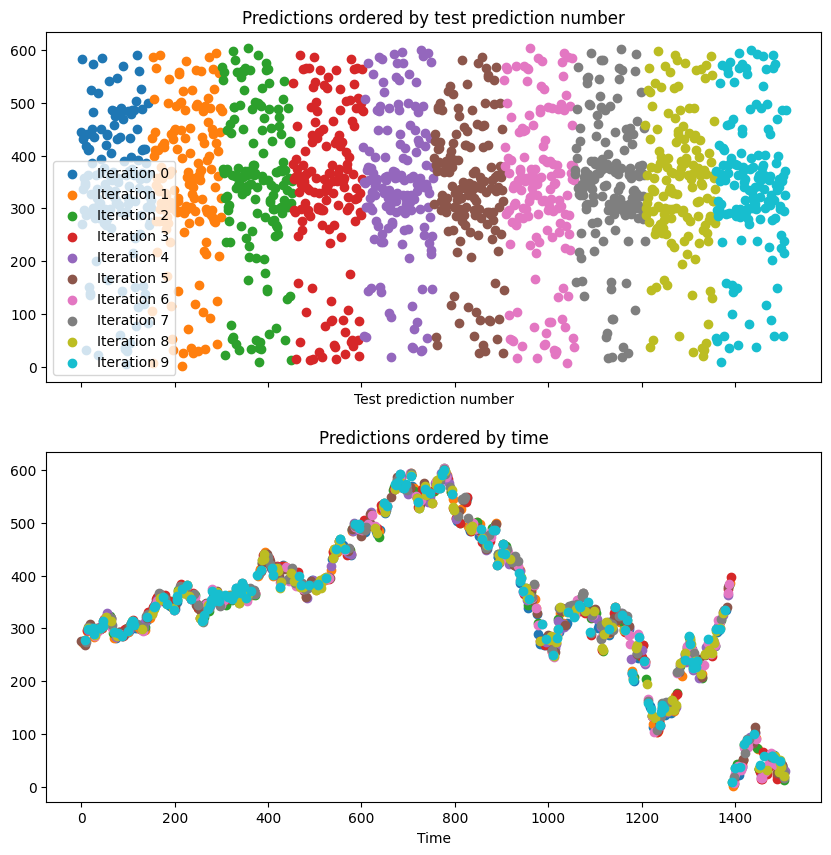

In [ ]:
model = LinearRegression()

cv = ShuffleSplit(n_splits=10, random_state=1)
# Use stock symbols to extract training data
X = all_prices[['EBAY','NVDA', 'YHOO']].values
y = all_prices['AAPL'].values

# Iterate through CV splits
results = []
for tr, tt in cv.split(X, y):
    # Fit the model on training data
    model.fit(X[tr], y[tr])
    
    # Generate predictions on the test data, score the predictions, and collect
    prediction = model.predict(X[tt])
    score = r2_score(y[tt], prediction)
    results.append((prediction, score, tt))

# Custom function to quickly visualize predictions
visualize_predictions(results)

If we look at the bottom plot, we can see that the order of datapoints in the test set is scrambled. Let's see how it looks when we shuffle the data in blocks.

Now, we re-run our model fit using block cross-validation (without shuffling all datapoints). In this case, neighboring time-points will be kept close to one another. How do you think the model predictions will look in each cross-validation loop?

In [55]:
def visualize_predictions(results):
    fig, axs = plt.subplots(2, 1, figsize=(10, 10), sharex=True)
    
    # Loop through our model results to visualize them
    for ii, (prediction, indices) in enumerate(results):
        # Plot the predictions of the model in the order they were generated
        offset = len(prediction) * ii
        axs[0].scatter(np.arange(len(prediction)) + offset, prediction, label='Iteration {}'.format(ii))
        
        # Plot the predictions of the model according to how time was ordered
        axs[1].scatter(indices, prediction)
    axs[0].legend(loc="best")
    axs[0].set(xlabel="Test prediction number", title="Predictions ordered by test prediction number")
    axs[1].set(xlabel="Time", title="Predictions ordered by time")
    plt.show()

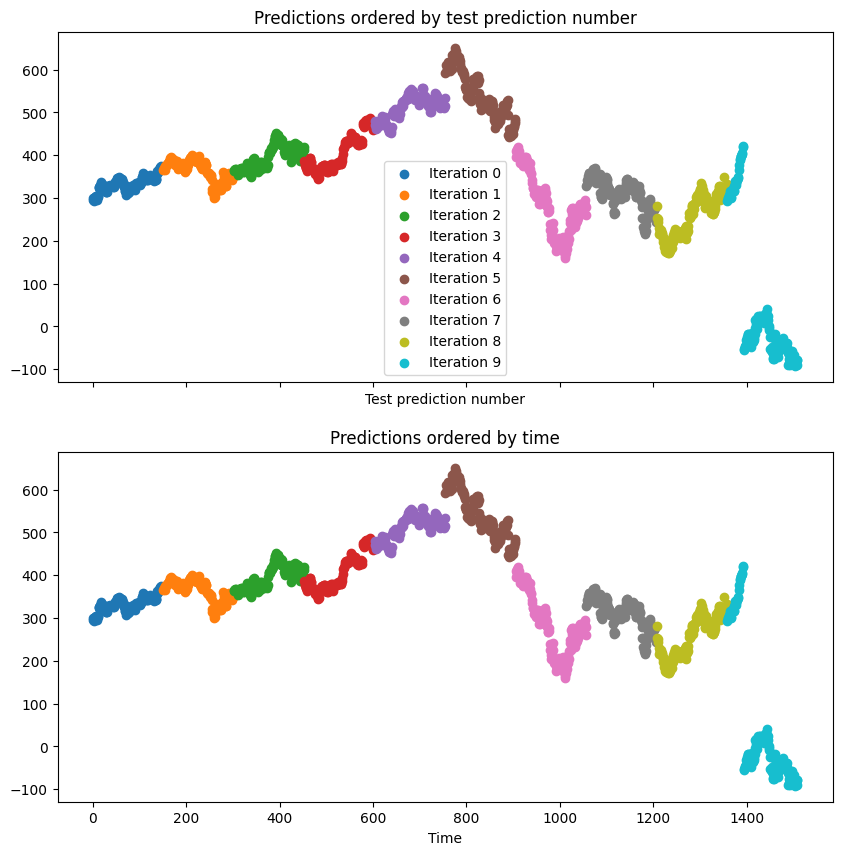

In [56]:
cv = KFold(n_splits=10, shuffle=False)

# Iterate through CV splits
results = []
for tr, tt in cv.split(X, y):
    # Fit the model on training data
    model.fit(X[tr], y[tr])
    
    # Generate predictions on the test data and collect
    prediction = model.predict(X[tt])
    results.append((prediction, tt))
    
# Custom function to quickly visualize predictions
visualize_predictions(results)

This time, the predictions generated within each CV loop look 'smoother' than they were before - they look more like a real time series because we didn't shuffle the data. This is a good sanity check to make sure your CV splits are correct.

Finally, let's visualize the behavior of the time series cross-validation iterator in scikit-learn. We will use this object to iterate through our data one last time, visualizing the training data used to fit the model on each iteration.

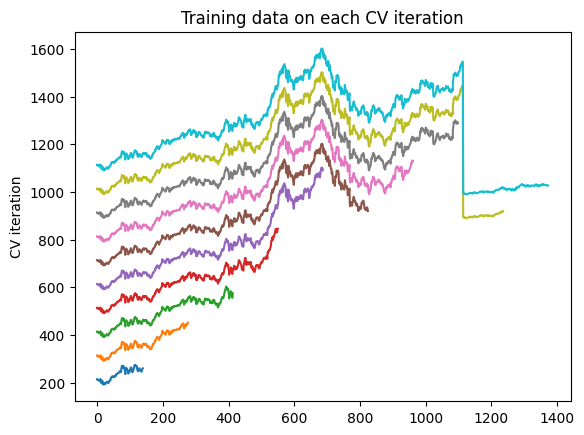

In [60]:
# Create time-series cross-validation object
cv = TimeSeriesSplit(n_splits=10)

# Iterate through CV splits
fig, ax = plt.subplots()
for ii, (tr, tt) in enumerate(cv.split(X, y)):
    # Plot the training data on each iteration, to see the behavior of the CV
    ax.plot(tr, 100*ii + y[tr])

ax.set(title='Training data on each CV iteration', ylabel='CV iteration')
plt.show()

Note that the size of the training set grew each time when we used the time series cross-validation object. This way, the time points we predict are always after the timepoints we train on.

#### Stationarity and stability

A useful tool for assessing the variability of some data is the bootstrap. In this exercise, we'll write our own bootstrapping function that can be used to return a bootstrapped confidence interval.

This function takes three parameters: a 2-D array of numbers (`data`), a list of percentiles to calculate (`percentiles`), and the number of boostrap iterations to use (`n_boots`). It uses the `resample` function to generate a bootstrap sample, and then repeats this many times to calculate the confidence interval.

In [62]:
def bootstrap_interval(data, percentiles=(2.5, 97.5), n_boots=100):
    """Bootstrap a confidence interval for the mean of columns of a 2-D dataset."""
    # Create our empty array to fill the results
    bootstrap_means = np.zeros([n_boots, data.shape[-1]])
    for ii in range(n_boots):
        # Generate random indices for our data *with* replacement, then take the sample mean
        random_sample = resample(data)
        bootstrap_means[ii] = random_sample.mean(axis=0)
        
    # Compute the percentiles of choice for the bootstrapped means
    percentiles = np.percentile(bootstrap_means, percentiles, axis=0)
    return percentiles

In this lesson, we'll re-run the cross-validation routine used before, but this time paying attention to the model's stability over time. We'll investigate the coefficients of the model, as well as the uncertainty in its predictions.

Begin by assessing the stability (or uncertainty) of a model's coefficients across multiple CV splits. Remember, the coefficients are a reflection of the pattern that our model has found in the data.

In [63]:
# Iterate through CV splits
n_splits = 100
cv = TimeSeriesSplit(n_splits=n_splits)

# Create empty array to collect coefficients
coefficients = np.zeros([n_splits, X.shape[1]])

for ii, (tr, tt) in enumerate(cv.split(X, y)):
    # Fit the model on training data and collect the coefficients
    model.fit(X[tr], y[tr])
    coefficients[ii] = model.coef_

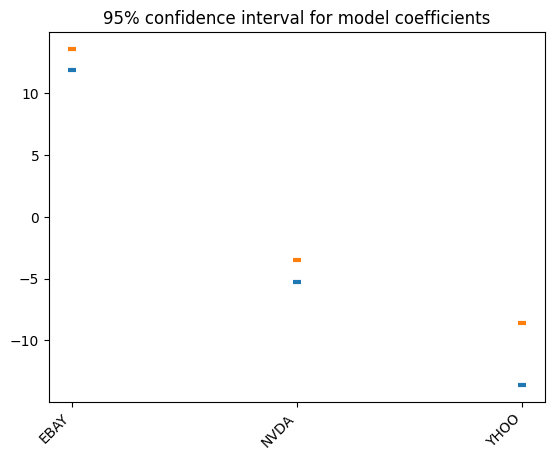

In [67]:
# Calculate a confidence interval around each coefficient
bootstrapped_interval = bootstrap_interval(coefficients, percentiles=(2.5, 97.5), n_boots=100)

# Plot it
fig, ax = plt.subplots()
ax.scatter(['EBAY','NVDA', 'YHOO'], bootstrapped_interval[0], marker='_', lw=3)
ax.scatter(['EBAY','NVDA', 'YHOO'], bootstrapped_interval[1], marker='_', lw=3)
ax.set(title='95% confidence interval for model coefficients')
plt.setp(ax.get_xticklabels(), rotation=45, horizontalalignment='right')
plt.show()

We've calculated the variability around each coefficient, which helps assess which coefficients are more stable over time!

Now that we've assessed the variability of each coefficient, let's do the same for the performance (scores) of the model. Recall that the `TimeSeriesSplit` object will use successively-later indices for each test set. This means that we can treat the scores of our validation as a time series. We can visualize this over time in order to see how the model's performance changes over time.

In [68]:
def my_pearsonr(est, X, y):
    return np.corrcoef(est.predict(X).squeeze(), y.squeeze())[1, 0]

cv = TimeSeriesSplit(n_splits=100)

In [74]:
# Generate scores for each split to see how the model performs over time
scores = cross_val_score(model, X, y, cv=cv, scoring=my_pearsonr)

# Convert to a Pandas Series object
scores_series = pd.Series(scores, name='score')

# Bootstrap a rolling confidence interval for the mean score
# scores_lo = scores_series.rolling(20).aggregate(partial(bootstrap_interval, percentiles=2.5))
# scores_hi = scores_series.rolling(20).aggregate(partial(bootstrap_interval, percentiles=97.5))

In [72]:
scores_series

0     0.158348
1     0.029742
2     0.073517
3     0.922431
4     0.015915
        ...   
95    0.345474
96    0.186697
97   -0.617749
98    0.475511
99    0.505817
Name: score, Length: 100, dtype: float64